# Testing the kinematic feature extraction code on Modelled Data

### Step 0: Make the modelled data
### Step 1: Plot and visualized what the expected results of modelled data are
### Step 2: Run the kinematic extraction code on the modelled data 
### Step 3: Plot the extracted kinematics for the modelled data
### Step 4: comapred the expectation and the results and make sure kinematic code works fine

In [1]:
%matplotlib inline

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from cv2 import VideoWriter, VideoWriter_fourcc
from celluloid import Camera
import pandas as pd
#import torch
from scipy import signal, ndimage, spatial
from scipy.signal import correlate
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter
import math 
#from signal_alignment import phase_align, chisqr_align
from scipy.interpolate import interp1d
import scipy.stats as stats
from scipy.stats import spearmanr
from plot_kinematics_basic import plot_kinematics 
from feature_eng import StrokeMetrics, ALSMetrics, ClinicalMetrics, ClinicalSignals

import get_onsets_basic

### Step 0: Make the modelled data

In [3]:
# CREATING A MODEL LOOKUP TABLE 
input_csv = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/Test_Table.csv"
out_path = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling"
csv_name = "model_lookup.csv"

model_lookup = pd.DataFrame()
from_example = pd.read_csv(input_csv)

try:
    from_example = from_example.drop(['Unnamed: 0'], axis=1)
    from_example.loc[0][['landmarks']] = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_BBP_NORMAL_landmarksFiltered3D.csv"
    from_example.loc[0][['landmarks_table']] = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_BBP_NORMAL_video.Table"
    from_example.loc[0][['rest']] = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_RST_REST_landmarksFiltered3D.csv"
except:
    pass


from_example.to_csv(os.path.join(out_path, csv_name))

In [4]:
# CREATING A MODEL REST csv
input_csv = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/video_data/ALS/old/A001/landmarks_finetuned_w15/A001_02_RST_REST_landmarksFiltered3D.csv"
out_path = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling"
csv_name = "NF000_02_RST_REST_landmarksFiltered3D.csv"


    

from_example = pd.read_csv(input_csv)
from_example = from_example.drop(['Unnamed: 0'], axis=1)
cols = from_example.columns
model_landmarks = pd.DataFrame(columns= cols)

model_landmarks['Video_Frame_number'] = np.array(range(100))+1
model_landmarks.loc[0] = from_example.loc[100].astype(np.float)
model_landmarks.loc[0, 'Video_Frame_number'] = 1
#model_landmarks.loc[0, 'Time_Stamp (s)'] = 0

#model_landmarks = model_landmarks['Video_Frame_number'].append(np.array(range(100))+2, ignore_index = True ) 
#model_landmarks.loc[1:100,'Video_Frame_number'] = np.array(range(99))+2
# sampling freq of 10 per second 
model_landmarks['Time_Stamp (s)'] = np.array(range(100))/50

model_landmarks = model_landmarks.fillna(model_landmarks.loc[0])

# initialize all the landmark poses to zero 
#model_landmarks[new_cols] = 1

model_landmarks.to_csv(os.path.join(out_path, csv_name))

#os.path.join(out_path, csv_name)



print('save at location:', os.path.join(out_path, csv_name))


save at location: /Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_RST_REST_landmarksFiltered3D.csv


In [60]:
# CREATING A MODEL Task Landmarks csv
#input_csv = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/video_data/ALS/old/A001/landmarks_finetuned_w15/A001_02_NSM_OPEN_landmarksFiltered3D.csv"
out_path = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling"
csv_name = "NF000_02_BBP_NORMAL_landmarksFiltered3D_withNoise.csv"


    



# model the opening: which is based on using landmarks [51 and 57]

# initialize x and z components to 1, and 

#model_landmarks['landmark_51'] = 1
#model_landmarks['landmark_57'] = 1

#model_landmarks['landmark_51.2'] = 1
#model_landmarks['landmark_57.2'] = 1

model_landmarks['landmark_57.1'] = model_landmarks['landmark_57.1'].values + (2*np.cos(np.linspace(-np.pi, 3*np.pi, 100))+2) + np.cos(np.linspace(-np.pi, 3*np.pi, 100)*20)
#model_landmarks['landmark_51.1'] = 1

# model the spread: which is based on using landmarks [48 and 54]

#model_landmarks['landmark_48'] = 1
model_landmarks['landmark_54'] = model_landmarks['landmark_54'].values + (2*np.cos(np.linspace(-np.pi, 3*np.pi, 100))+2) + np.cos(np.linspace(-np.pi, 3*np.pi, 100)*20)

#model_landmarks['landmark_48.1'] = 1
#model_landmarks['landmark_54.1'] = 1

#model_landmarks['landmark_48.2'] = 1
#model_landmarks['landmark_54.2'] = 1


# model the distance from eye corners: which is based on using landmarks [42, 54], [39, 48]



# model the mouth left and right areas: which is based on using landmarks [48 and 54]
model_landmarks.to_csv(os.path.join(out_path, csv_name))

print('save at location:', os.path.join(out_path, csv_name))

save at location: /Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_BBP_NORMAL_landmarksFiltered3D_withNoise.csv


### Generating cosine signal 

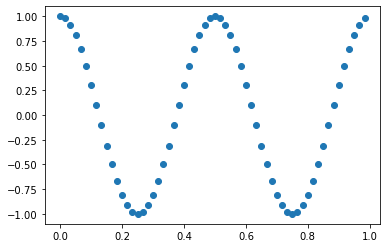

60

In [6]:
import numpy as np
from matplotlib import pyplot as plt

SAMPLE_RATE = 60  # Hertz
DURATION = 1  # Seconds

def generate_cosine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi because np.sin takes radians
    y = np.cos((2 * np.pi) * frequencies)
    return x, y

# Generate a 2 hertz sine wave that lasts for 5 seconds
x, y = generate_cosine_wave(2, SAMPLE_RATE, DURATION)
plt.plot(x, y,'o')
plt.show()
len(x)

In [7]:
a = model_landmarks['landmark_54'].values
#a = a + np.cos(np.linspace(-np.pi, 3*np.pi, 100)) + np.cos(np.linspace(-np.pi, 3*np.pi, 100)*20)



100
5.611849549388857


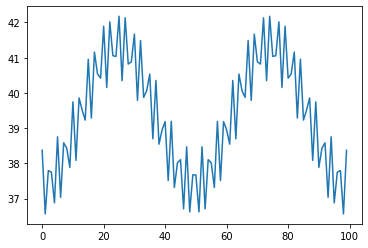

In [59]:

plt.plot(model_landmarks['landmark_54'].values)
print(len(model_landmarks['landmark_54'].values))

print(model_landmarks['landmark_54'].values.max() - model_landmarks['landmark_54'].values.min())

### Filters 



In [9]:
def create_filter(time_stamps, highcut, filter_order):
    
    
    fs = int(1 / (time_stamps[1] - time_stamps[0]))
    print(fs)
    nyq = 0.5 * fs
    high = highcut / nyq
    print(high)
    b, a = signal.butter(filter_order, high, btype='low', output='ba')
    return np.array([b, a])

In [10]:
# cut off freq 
cf = 12.5
# number of poles
p = 4
[b,a] = create_filter(model_landmarks['Time_Stamp (s)'].to_numpy(), cf, p)
#f_vertical = signal.filtfilt(b, a, model_landmarks['landmark_54'].values)

50
0.5


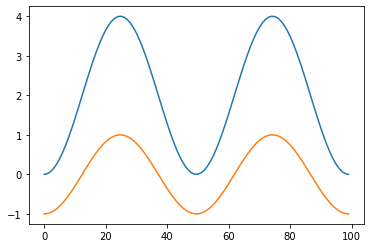

In [11]:
#x= np.array(range(100))* np.pi / 180.
x = np.linspace(-np.pi, 3*np.pi, 100)
plt.plot((2*np.cos(x)+2))
#plt.plot(x)



plt.plot(np.cos(np.linspace(-np.pi, 3*np.pi, 100)))

In [12]:
# Some helper functions

# Used to extract the patient type from the landmark file name
ids = {
    "stroke": ["OP", "S"],
    "healthy": ["N"],
    "als": ["A"]
}

# Defines which metric calculator to use based on the 'metric_type' argument
metric_calc_map = {
    "orofacial_features": ClinicalMetrics,
    "orofacial_signals": ClinicalSignals
}


def compute_metrics(inputs, out_path, metrics_type = 'orofacial_features'):
    """
    Computes the metrics for every file in the data csv
    :param inputs: A dataframe with columns: csv_path, rep_{}_start,
                                                       rep_{}_end
    :param out_path: A path to a csv to store the metric data in
    """
    # Key is task name and value is all repetitions of the task
    metric_frames: Dict[str, List[pd.DataFrame]] = {}
    for index, row in inputs.iterrows():
        # Read all data from the input dataframe
        try:
            data_path = row['csv_path']
            rest_path = row['rest_path']
            data_frame = pd.read_csv(data_path)
            rest_frame = pd.read_csv(rest_path)
            task_type = row['task']
            subject_id = row['subject']
            subject_type = row['type']
        except KeyError:
            raise KeyError("Input csv must contain 'csv_path', 'rest_path', 'rest_table_path' \
            'task', 'subject', and 'type' columns. \nFurthermore, 'csv_path' \
            and 'rest_path' must be files on the disk.")
        print("Starting:", data_path, "with", subject_type, "patients")
        rep_ranges = []
        rep_i = 1
        # Grab data about the start and end of repetitions
        while f"rep_{rep_i}_start" in row and f"rep_{rep_i}_end" in row:
            try:
                start_val = row[f"rep_{rep_i}_start"]
                end_val = row[f"rep_{rep_i}_end"]
                rep_ranges.append(range(int(start_val), int(end_val)))
            except ValueError as e:
                pass
            rep_i += 1
        rep_i -= 1

        # Calculate metrics
        metric_calc = metric_calc_map[metrics_type](data_frame, rest_frame)

        metric_frame = None
        for rep_range in rep_ranges:
            metrics = metric_calc.compute_metrics(active_frames=rep_range)
            print()
            print(metrics)
            print()
            if metric_frame is None:
                metric_frame = metrics
            else:
                metric_frame = pd.concat([metric_frame, metrics], ignore_index=True)
        rep_nums = list(range(1, rep_i+1))

        # Insert metadata to final csv
        metric_frame.insert(0, 'rep', pd.Series(rep_nums))
        metric_frame.insert(0, 'type', pd.Series(np.full(rep_i, int(not(subject_type == "healthy")))))
        metric_frame.insert(0, 'task', pd.Series(np.full(rep_i, task_type)))
        metric_frame.insert(0, 'subject_id', pd.Series(np.full(rep_i, subject_id)))
        try:
            metric_frames[task_type].append(metric_frame)
        except KeyError:
            metric_frames[task_type] = [metric_frame]

    # save data to disk
    for task, metrics in metric_frames.items():
        csv_name = "{}_metric_output_{}.csv".format(metrics_type,task)
        
        all_metrics_frame = pd.concat(metrics, ignore_index=True)

        
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        all_metrics_frame.to_csv(os.path.join(out_path, csv_name))
        
    print(f"Saved metrics to {os.path.abspath(out_path)}")
    return metric_frames



def compute_signals(inputs, out_path, metrics_type = 'orofacial_signals'):
    """
    Computes the metrics for every file in the data csv
    :param inputs: A dataframe with columns: csv_path, rep_{}_start,
                                                       rep_{}_end
    :param out_path: A path to a csv to store the metric data in
    """
    # Key is task name and value is all repetitions of the task
    metric_frames: Dict[str, List[pd.DataFrame]] = {}
    for index, row in inputs.iterrows():
        # Read all data from the input dataframe
        try:
            data_path = row['csv_path']
            rest_path = row['rest_path']
            data_frame = pd.read_csv(data_path)
            rest_frame = pd.read_csv(rest_path)
            task_type = row['task']
            subject_id = row['subject']
            subject_type = row['type']
        except KeyError:
            raise KeyError("Input csv must contain 'csv_path', 'rest_path', 'rest_table_path' \
            'task', 'subject', and 'type' columns. \nFurthermore, 'csv_path' \
            and 'rest_path' must be files on the disk.")
        print("Starting:", data_path, "with", subject_type, "patients")
        rep_ranges = []
        rep_i = 1
        # Grab data about the start and end of repetitions
        while f"rep_{rep_i}_start" in row and f"rep_{rep_i}_end" in row:
            try:
                start_val = row[f"rep_{rep_i}_start"]
                end_val = row[f"rep_{rep_i}_end"]
                rep_ranges.append(range(int(start_val), int(end_val)))
            except ValueError as e:
                pass
            rep_i += 1
        rep_i -= 1

        # Calculate metrics
        metric_calc = metric_calc_map[metrics_type](data_frame, rest_frame)

        metric_frame = None
        
        for rep_range in rep_ranges:
            
            metrics = metric_calc.compute_metrics(active_frames=rep_range)
            
            metrics.insert(0, 'Time_Stamp', data_frame.loc[rep_range]['Time_Stamp (s)'].values)
            metrics.insert(0, 'type', pd.Series(np.full(len(metrics), int(not(subject_type == "healthy")))))
            metrics.insert(0, 'task', pd.Series(np.full(len(metrics), task_type)))
            metrics.insert(0, 'rep', pd.Series(np.full(len(metrics), rep_ranges.index(rep_range))))
            metrics.insert(0, 'subject_id', pd.Series(np.full(len(metrics), subject_id)))
            
            
            if metric_frame is None:
                metric_frame = metrics
            else:
                metric_frame = pd.concat([metric_frame, metrics], ignore_index=True)
      

        # Insert metadata to final csv
        
        
        
        try:
            metric_frames[task_type].append(metric_frame)
        except KeyError:
            metric_frames[task_type] = [metric_frame]

    # save data to disk
    for task, metrics in metric_frames.items():
        csv_name = "{}_metric_output_{}.csv".format(metrics_type,task)
        
        all_metrics_frame = pd.concat(metrics, ignore_index=True)

        
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        all_metrics_frame.to_csv(os.path.join(out_path, csv_name))
        
    print(f"Saved metrics to {os.path.abspath(out_path)}")
    return metric_frames




In [13]:
def save_results(input_csv, output_folder, metric_type):
    analysis_csv = pd.DataFrame()
    files = pd.read_csv(input_csv)
    for i, row in files.iterrows():
        # Construct a dataframe with the information necessary for processing
        landmark_path = os.path.abspath(row["landmarks"])
        landmark_file_name = os.path.basename(landmark_path)
        table_path = os.path.abspath(row["landmarks_table"])
        table_file_name = os.path.basename(table_path)
        rest_path = os.path.abspath(row["rest"])
        rest_file_name = os.path.basename(table_path)
        print(landmark_path)
        print()
        print(rest_path)
        print()
        print(table_path)

        if not os.path.isfile(landmark_path):
            raise RuntimeError("Landmark path is not a file on disk")
        if not os.path.isfile(rest_path):
            raise RuntimeError("Rest file is not a file on disk")
        if not os.path.isfile(table_path):
            raise RuntimeError("Table file is not a file on disk")

        landmark_file_data = landmark_file_name.split("_")
        subject = landmark_file_data[0]
        subject_type = ""
        # Check if a user fits into a known subject type
        for s_type, prefixes in ids.items():
            for prefix in prefixes:
                if prefix in subject:
                    subject_type = s_type
        task = "_".join(landmark_file_data[2:4])
        parsed_data = pd.DataFrame(columns=["csv_path", "type", "rest_path", "subject", "task"])
        parsed_data.loc[0] = 0

        
     
        video_info = pd.read_csv(table_path)


        parsed_data["csv_path"] = landmark_path
        parsed_data["rest_path"] = rest_path
        parsed_data["type"] = subject_type
        parsed_data["subject"] = subject
        parsed_data["task"] = task
        for index, row in video_info.iterrows():
            parsed_data[f"rep_{index+1}_start"] = row[video_info.columns[0]]
            parsed_data[f"rep_{index+1}_end"] = row[video_info.columns[-1]] 
        analysis_csv = analysis_csv.append(parsed_data, ignore_index=True, sort=False)


    if metric_type == 'orofacial_signals':
        compute_signals(analysis_csv, output_folder,metric_type);
        
    else:
        compute_metrics(analysis_csv, output_folder,metric_type);

In [14]:
# Try with mini lookup table of 1 modelled data

metric_type = 'orofacial_signals' 

 #csv file with modelled fake landmarks info and the made up .TABLE info
input_csv = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/model_lookup.csv"
#where to store the results
output_folder = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling" 
save_results(input_csv, output_folder, metric_type)




/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_BBP_NORMAL_landmarksFiltered3D.csv

/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_RST_REST_landmarksFiltered3D.csv

/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_BBP_NORMAL_video.Table
Starting: /Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_BBP_NORMAL_landmarksFiltered3D.csv with healthy patients
shape of the data is 
shape of the data is 
shape of the data is 
shape of the data is 
shape of the data is 
(99, 2, 3)
active features in eval_feature
[10.30774979 10.30774979 10.38048616 10.48082572 10.60728707 10.75798268
 10.93063594 11.12260556 11.33091805 11.55230848 11.78326912 12.02010497
 12.25899486 12.49605656 12.72741418 12.94926621 13.15795258 13.35001929
 13.52227934 13.67186874 13.79629669 13.89348904 13.96182433 13.98479473
 13.98479473 13.98479473 13.93134665 13.84840964 13.7373677

/Users/denizjafari/Documents/CODE/ClinicalScore/ClinicalScore/feature_eng.py:400: RuntimeWarning: invalid value encountered in true_divide
  z_scores = (feature - mean) / sd


shape of the data is 
shape of the data is 
shape of the data is 
shape of the data is 
shape of the data is 
(99, 2, 3)
active features in eval_feature
[53.96006998 53.96006998 54.03840601 54.14631001 54.28204933 54.44344401
 54.62790158 54.83245844 55.05382724 55.28844956 55.5325529  55.78221124
 56.03340814 56.28210132 56.52428775 56.75606821 56.97371015 57.17370799
 57.35283974 57.50821909 57.63734208 57.73812764 57.80895127 57.83275117
 57.83275117 57.83275117 57.77736763 57.69138962 57.57620303 57.43366443
 57.26607096 57.07612324 56.86688159 56.64171664 56.40425476 56.15831957
 55.90787018 55.65693736 55.40955861 55.16971317 54.94125804 54.72786606
 54.53296699 54.35969256 54.21082639 54.08875946 53.99545199 53.93240213
 53.93240213 53.93240213 53.93240213 53.99545199 54.08875946 54.21082639
 54.35969256 54.53296699 54.72786606 54.94125804 55.16971317 55.40955861
 55.65693736 55.90787018 56.15831957 56.40425476 56.64171664 56.86688159
 57.07612324 57.26607096 57.43366443 57.5762

shape of the data is 
shape of the data is 
shape of the data is 
shape of the data is 
shape of the data is 
(99, 2, 3)
active features in eval_feature
[53.96006998 53.96006998 54.03840601 54.14631001 54.28204933 54.44344401
 54.62790158 54.83245844 55.05382724 55.28844956 55.5325529  55.78221124
 56.03340814 56.28210132 56.52428775 56.75606821 56.97371015 57.17370799
 57.35283974 57.50821909 57.63734208 57.73812764 57.80895127 57.83275117
 57.83275117 57.83275117 57.77736763 57.69138962 57.57620303 57.43366443
 57.26607096 57.07612324 56.86688159 56.64171664 56.40425476 56.15831957
 55.90787018 55.65693736 55.40955861 55.16971317 54.94125804 54.72786606
 54.53296699 54.35969256 54.21082639 54.08875946 53.99545199 53.93240213
 53.93240213 53.93240213 53.93240213 53.99545199 54.08875946 54.21082639
 54.35969256 54.53296699 54.72786606 54.94125804 55.16971317 55.40955861
 55.65693736 55.90787018 56.15831957 56.40425476 56.64171664 56.86688159
 57.07612324 57.26607096 57.43366443 57.5762

In [15]:
metric_type = 'orofacial_features' 

 #csv file with modelled fake landmarks info and the made up .TABLE info
input_csv = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/model_lookup.csv"
#where to store the results
output_folder = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling"
save_results(input_csv, output_folder, metric_type)


/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_BBP_NORMAL_landmarksFiltered3D.csv

/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_RST_REST_landmarksFiltered3D.csv

/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_BBP_NORMAL_video.Table
Starting: /Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_BBP_NORMAL_landmarksFiltered3D.csv with healthy patients
shape of the data is 
shape of the data is 
shape of the data is 
shape of the data is 
shape of the data is 
(99, 2, 3)
active features in eval_feature
[10.30774979 10.30774979 10.38048616 10.48082572 10.60728707 10.75798268
 10.93063594 11.12260556 11.33091805 11.55230848 11.78326912 12.02010497
 12.25899486 12.49605656 12.72741418 12.94926621 13.15795258 13.35001929
 13.52227934 13.67186874 13.79629669 13.89348904 13.96182433 13.98479473
 13.98479473 13.98479473 13.93134665 13.84840964 13.7373677

shape of the data is 
shape of the data is 
shape of the data is 
shape of the data is 
shape of the data is 
(99, 2, 3)
active features in eval_feature
[57.21828809 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809
 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809
 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809
 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809
 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809
 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809
 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809
 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809
 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809
 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809
 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809 57.21828809
 57.21828809 57.21828809 57.21828809 57.2182

shape of the data is 
shape of the data is 
shape of the data is 
shape of the data is 
shape of the data is 
(99, 2, 3)
active features in eval_feature
[118.24750186 118.24750186 118.24750186 118.24750186 118.24750186
 118.24750186 118.24750186 118.24750186 118.24750186 118.24750186
 118.24750186 118.24750186 118.24750186 118.24750186 118.24750186
 118.24750186 118.24750186 118.24750186 118.24750186 118.24750186
 118.24750186 118.24750186 118.24750186 118.24750186 118.24750186
 118.24750186 118.24750186 118.24750186 118.24750186 118.24750186
 118.24750186 118.24750186 118.24750186 118.24750186 118.24750186
 118.24750186 118.24750186 118.24750186 118.24750186 118.24750186
 118.24750186 118.24750186 118.24750186 118.24750186 118.24750186
 118.24750186 118.24750186 118.24750186 118.24750186 118.24750186
 118.24750186 118.24750186 118.24750186 118.24750186 118.24750186
 118.24750186 118.24750186 118.24750186 118.24750186 118.24750186
 118.24750186 118.24750186 118.24750186 118.24750186 11

shape of the data is 
shape of the data is 
shape of the data is 
shape of the data is 
shape of the data is 
(99, 2, 3)
active features in eval_feature
[53.96006998 53.96006998 54.03840601 54.14631001 54.28204933 54.44344401
 54.62790158 54.83245844 55.05382724 55.28844956 55.5325529  55.78221124
 56.03340814 56.28210132 56.52428775 56.75606821 56.97371015 57.17370799
 57.35283974 57.50821909 57.63734208 57.73812764 57.80895127 57.83275117
 57.83275117 57.83275117 57.77736763 57.69138962 57.57620303 57.43366443
 57.26607096 57.07612324 56.86688159 56.64171664 56.40425476 56.15831957
 55.90787018 55.65693736 55.40955861 55.16971317 54.94125804 54.72786606
 54.53296699 54.35969256 54.21082639 54.08875946 53.99545199 53.93240213
 53.93240213 53.93240213 53.93240213 53.99545199 54.08875946 54.21082639
 54.35969256 54.53296699 54.72786606 54.94125804 55.16971317 55.40955861
 55.65693736 55.90787018 56.15831957 56.40425476 56.64171664 56.86688159
 57.07612324 57.26607096 57.43366443 57.5762

//anaconda3/envs/ClinicalScore36/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/denizjafari/Documents/CODE/ClinicalScore/ClinicalScore/feature_eng.py:400: RuntimeWarning: invalid value encountered in true_divide
  z_scores = (feature - mean) / sd


shape of the data is 
shape of the data is 
shape of the data is 
shape of the data is 
shape of the data is 
(99, 2, 3)
active features in eval_feature
[10.30774979 10.30774979 10.38048616 10.48082572 10.60728707 10.75798268
 10.93063594 11.12260556 11.33091805 11.55230848 11.78326912 12.02010497
 12.25899486 12.49605656 12.72741418 12.94926621 13.15795258 13.35001929
 13.52227934 13.67186874 13.79629669 13.89348904 13.96182433 13.98479473
 13.98479473 13.98479473 13.93134665 13.84840964 13.73736776 13.60007284
 13.43881234 13.25626952 13.05547654 12.83976124 12.61268851 12.37799742
 12.13953515 11.90118926 11.66681976 11.44019268 11.2249167  11.0243847
 10.84172148 10.67973901 10.54089979 10.42728845 10.3405912  10.28208187
 10.28208187 10.28208187 10.28208187 10.3405912  10.42728845 10.54089979
 10.67973901 10.84172148 11.0243847  11.2249167  11.44019268 11.66681976
 11.90118926 12.13953515 12.37799742 12.61268851 12.83976124 13.05547654
 13.25626952 13.43881234 13.60007284 13.73736

shape of the data is 
shape of the data is 
shape of the data is 
shape of the data is 
shape of the data is 
(99, 2, 3)
active features in eval_feature
[55.73194778 55.73194778 55.77448778 55.83321307 55.90729826 55.99569047
 56.09711692 56.21009541 56.3329483  56.4638204  56.60070106 56.74145066
 56.88383137 57.02554184 57.16425539 57.29766078 57.42350485 57.5396357
 57.64404552 57.73491155 57.81063434 57.86987183 57.91156844 57.92559322
 57.92559322 57.92559322 57.89296685 57.84238674 57.77475613 57.69127713
 57.59342446 57.48291378 57.36166535 57.23176429 57.09541854 56.95491568
 56.81257991 56.6707302  56.53164071 56.39750426 56.27039958 56.15226262
 56.04486229 55.94978049 55.86839623 55.80187345 55.75115207 55.7169417
 55.7169417  55.7169417  55.7169417  55.75115207 55.80187345 55.86839623
 55.94978049 56.04486229 56.15226262 56.27039958 56.39750426 56.53164071
 56.6707302  56.81257991 56.95491568 57.09541854 57.23176429 57.36166535
 57.48291378 57.59342446 57.69127713 57.774756

//anaconda3/envs/ClinicalScore36/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
//anaconda3/envs/ClinicalScore36/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [16]:
modelled_signal = np.cos(np.linspace(-np.pi, 3*np.pi, 100))+1

#print(modelled_signal)


### Extracted features

In [17]:
# reading the data

input_csv_features = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/orofacial_features_metric_output_BBP_NORMAL.csv"
input_csv_signals = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/orofacial_signals_metric_output_BBP_NORMAL.csv"
input_csv_landmarks = r'/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_BBP_NORMAL_landmarksFiltered3D.csv'
input_csv_rest = r'/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_RST_REST_landmarksFiltered3D.csv'
df_mf = pd.read_csv(input_csv_features)
df_ms = pd.read_csv(input_csv_signals)
df_ml = pd.read_csv(input_csv_landmarks)
df_mr = pd.read_csv(input_csv_rest)
df_mf.head()

,Unnamed: 0,subject_id,task,type,rep,O_MAX,O_MIN,O_AVG,O_RANGE,O_PATH,...,tJA_RANGE,rJA_Max,rJA_MIN,rJA_AVG,rJA_RANGE,lJA_Max,lJA_MIN,lJA_AVG,lJA_RANGE,JA_diff
0,0,NF000,BBP_NORMAL,0,1,3.742634,0.026348,1.852990,3.716286,92.649484,...,123.095588,5.684342e-14,5.684342e-14,5.684342e-14,0.0,123.853447,0.757859,59.625453,123.095588,59.625453
1,1,NF000,BBP_NORMAL,0,2,3.742633,0.014501,1.888876,3.728132,92.554916,...,123.438134,5.684342e-14,5.684342e-14,5.684342e-14,0.0,123.853414,0.415280,60.786720,123.438134,60.786720


In [18]:
print(df_mf.O_MAX[0], modelled_signal.max())
print(df_mf.O_MIN[0], modelled_signal.min())


3.7426339585440864 1.9994965423831852
0.02634807946791007 0.0


In [19]:
df_ml.head()

,Unnamed: 0,Video_Frame_number,Time_Stamp (s),landmark_0,landmark_0.1,landmark_0.2,landmark_1,landmark_1.1,landmark_1.2,landmark_2,...,landmark_64.2,landmark_65,landmark_65.1,landmark_65.2,landmark_66,landmark_66.1,landmark_66.2,landmark_67,landmark_67.1,landmark_67.2
0,0,1.0,0.00,0.0,0.0,0.0,-80.554515,38.016702,760.0,-0.0,...,545.0,19.929108,45.525739,539.0,9.317505,45.610203,540.0,-1.343397,46.926355,545.0
1,1,2.0,0.02,0.0,0.0,0.0,-80.554515,38.016702,760.0,-0.0,...,545.0,19.929108,45.525739,539.0,9.317505,45.610203,540.0,-1.343397,46.926355,545.0
2,2,3.0,0.04,0.0,0.0,0.0,-80.554515,38.016702,760.0,-0.0,...,545.0,19.929108,45.525739,539.0,9.317505,45.610203,540.0,-1.343397,46.926355,545.0
3,3,4.0,0.06,0.0,0.0,0.0,-80.554515,38.016702,760.0,-0.0,...,545.0,19.929108,45.525739,539.0,9.317505,45.610203,540.0,-1.343397,46.926355,545.0
4,4,5.0,0.08,0.0,0.0,0.0,-80.554515,38.016702,760.0,-0.0,...,545.0,19.929108,45.525739,539.0,9.317505,45.610203,540.0,-1.343397,46.926355,545.0


### Calculating the values to validate against 

In [46]:
# cleaning video data 

def cleaning_video_df(DF):
    
    # choose the needed columns and convert the values to mm
    DF = DF[['Time_Stamp (s)','Video_Frame_number',
             'landmark_48', 'landmark_48.1', 'landmark_48.2', 'landmark_54',
            'landmark_54.1', 'landmark_54.2', 'landmark_51', 'landmark_51.1',
            'landmark_51.2', 'landmark_57', 'landmark_57.1', 'landmark_57.2']]
  
    
    DF = DF.rename(columns={'Time_Stamp (s)': 'Time', "landmark_48": "X_LR", "landmark_48.1": "Y_LR",
                           "landmark_48.2": "Z_LR", "landmark_54": "X_LLeft",
                           "landmark_54.1": "Y_LLeft", "landmark_54.2": "Z_LLeft",
                           "landmark_51": "X_UL", "landmark_51.1": "Y_UL",
                           "landmark_51.2": "Z_UL", "landmark_57": "X_LL", "landmark_57.1": "Y_LL",
                           "landmark_57.2": "Z_LL"})
    
    DF = DF.astype({ "X_LR": np.double, "Y_LR": np.double,"Z_LR": np.double, "X_LLeft": np.double,
                            "Y_LLeft": np.double, "Z_LLeft": np.double, "X_UL": np.double,  "Y_UL": np.double,
                            "Z_UL": np.double,  "X_LL": np.double,  "Y_LL": np.double, "Z_LL": np.double})
    
    # conver the values from mm to cm
    DF[["X_LR", "Y_LR","Z_LR", "X_LLeft", "Y_LLeft", "Z_LLeft", "X_UL",  "Y_UL","Z_UL",  "X_LL", 
       "Y_LL", "Z_LL"]] =  DF[["X_LR", "Y_LR","Z_LR", "X_LLeft", "Y_LLeft", "Z_LLeft", "X_UL",  "Y_UL","Z_UL",  "X_LL", 
       "Y_LL", "Z_LL"]]
    return DF

def area_of_triangle(A,B,C):

    """
    computes the area of a triangle given by 3 points in 2d or 3d

    A, B and C must be numpy arrays

    it works with vectors A=[a1,a2,a3], B=[b1,b2,b3], c=[c1,c2,c3] or matrices

    A=[[a11,a12,a13],...[a1n,a2n,b3n]], B=[[b11,b12,b13],...[b1n,b2n,b3n]], C=[[c11,c12,c13],...[c1n,c2n,c3n]]

    """

    As = A.shape
    
    Bs = B.shape
    
    Cs = C.shape
 
   
    if len(As) == 1 :

        #we got vectors

        if (As[0]>3) or (Bs[0]>3) or (Cs[0]>3):

            raise Exception('coordinates can only be 2d or 3d')

            return None

    else:

        #check at least one of the dimensions is two or three
        if (As[0]==2) or (As[0]==3) or (As[1]==2) or (As[1]==3):

            #one of the dimensions of A is 2 or 3, now check that all the vectors have the same size
            if (As!=Bs) or (As!=Cs):

                raise Exception('vectors must be the same size')
                return None

            else:
                #move forward
                pass

        else:

            raise Exception('coordinates can only be 2d or 3d')

            return None

    #at this point we know that one of the dimensions has 2 or 3 elements we move forward assuming that
    #the user provided the vectors with the correct size
    #move all vectors to the same origin

    AB = B-A
    AC = C-A  

    if len(As) == 1 :

        #if only one vector the simply compute the norm of the cross product
        area = (1/2)*np.linalg.norm(np.cross(AB,AC))

    else:

        #if only multiple vectors compute the norm along the axis one
        area = (1/2)*np.linalg.norm(np.cross(AB,AC), axis = 1)   

    return area

def lipDist(DF):
    
    # Assumes columns are named in a particular way 
    
    DF['W'] = DF.apply(lambda row: math.sqrt((row.X_LLeft - row.X_LR)**2 + (row.Y_LLeft - row.Y_LR)**2
                                                                  + (row.Z_LLeft - row.Z_LR)**2), axis = 1) 
    DF['O'] = DF.apply(lambda row: math.sqrt((row.X_UL - row.X_LL)**2 + (row.Y_UL - row.Y_LL)**2 +
                                                                 (row.Z_UL - row.Z_LL)**2), axis = 1)
    return DF

In [21]:
df_ml_2 = df_ml.drop(0,axis=0)
df_ml_2 = cleaning_video_df(df_ml_2)
df_ml_2 = lipDist(df_ml_2)
df_ml_2.head()

,Time,Video_Frame_number,X_LR,Y_LR,Z_LR,X_LLeft,Y_LLeft,Z_LLeft,X_UL,Y_UL,Z_UL,X_LL,Y_LL,Z_LL,W,O
1,0.02,2.0,-15.960541,55.069276,555.0,37.387995,51.678442,548.0,9.352014,41.334554,542.0,10.167091,50.751495,538.0,53.912560,10.263681
2,0.04,3.0,-15.960541,55.069276,555.0,37.436007,51.678442,548.0,9.352014,41.334554,542.0,10.167091,50.799508,538.0,53.960070,10.307750
3,0.06,4.0,-15.960541,55.069276,555.0,37.515169,51.678442,548.0,9.352014,41.334554,542.0,10.167091,50.878669,538.0,54.038406,10.380486
4,0.08,5.0,-15.960541,55.069276,555.0,37.624206,51.678442,548.0,9.352014,41.334554,542.0,10.167091,50.987706,538.0,54.146310,10.480826
5,0.10,6.0,-15.960541,55.069276,555.0,37.761364,51.678442,548.0,9.352014,41.334554,542.0,10.167091,51.124865,538.0,54.282049,10.607287


In [22]:
df_mr_2 = df_mr.drop(0,axis=0)
df_mr_2 = cleaning_video_df(df_mr_2)
df_mr_2 = lipDist(df_mr_2)
df_mr_2.head()

,Time,Video_Frame_number,X_LR,Y_LR,Z_LR,X_LLeft,Y_LLeft,Z_LLeft,X_UL,Y_UL,Z_UL,X_LL,Y_LL,Z_LL,W,O
1,0.02,2.0,-15.960541,55.069276,555.0,37.371905,51.678442,548.0,9.352014,41.334554,542.0,10.167091,50.735405,538.0,53.896638,10.24892
2,0.04,3.0,-15.960541,55.069276,555.0,37.371905,51.678442,548.0,9.352014,41.334554,542.0,10.167091,50.735405,538.0,53.896638,10.24892
3,0.06,4.0,-15.960541,55.069276,555.0,37.371905,51.678442,548.0,9.352014,41.334554,542.0,10.167091,50.735405,538.0,53.896638,10.24892
4,0.08,5.0,-15.960541,55.069276,555.0,37.371905,51.678442,548.0,9.352014,41.334554,542.0,10.167091,50.735405,538.0,53.896638,10.24892
5,0.10,6.0,-15.960541,55.069276,555.0,37.371905,51.678442,548.0,9.352014,41.334554,542.0,10.167091,50.735405,538.0,53.896638,10.24892


Text(0, 0.5, 'Range of Motion (cm)')

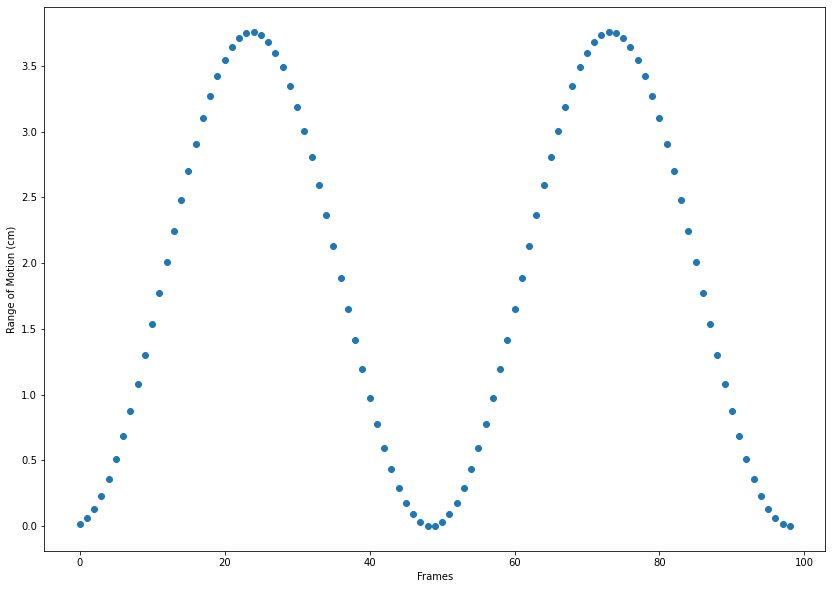

In [23]:
a = df_ml_2.O.values - df_mr_2.O.values

ax, figure = plt.subplots(figsize=(14,10))
plt.plot(a,'o')
plt.xlabel('Frames')
plt.ylabel('Range of Motion (cm)')

In [24]:
b = np.linalg.norm(df_ml_2[['X_UL', 'Y_UL', 'Z_UL']].values - df_ml_2[['X_LL', 'Y_LL', 'Z_LL']].values, axis=1)

rest = np.linalg.norm(df_mr_2[['X_UL', 'Y_UL', 'Z_UL']].values - df_mr_2[['X_LL', 'Y_LL', 'Z_LL']].values, axis=1)
c = b-rest

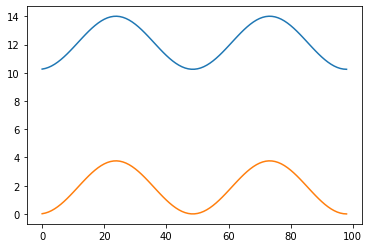

In [25]:
plt.plot(b)
plt.plot(c)

In [28]:

print(df_ms.loc[df_ms['rep'] == 0, 'O'].values.max() - df_ms.loc[df_ms['rep'] == 0, 'O'].values.min(),a[0:50].max() - a[0:50].min(), df_mf.O_RANGE[0], df_mf.O_MAX[0]- df_mf.O_MIN[0])

3.7162858790761764 3.755248078619619 3.716285879076176 3.7162858790761764


In [84]:
# VALIDATING THE DATA 
print(df_ms.loc[df_ms['rep'] == 0, 'O'].values.max(),df_mf.O_MAX[0], a.max())
print(df_ms.loc[df_ms['rep'] == 0, 'O'].values.min(),df_mf.O_MIN[0], a.min())

3.7426339585440864 3.7426339585440864 3.7589416577707784
0.02634807946791007 0.02634807946791007 0.0


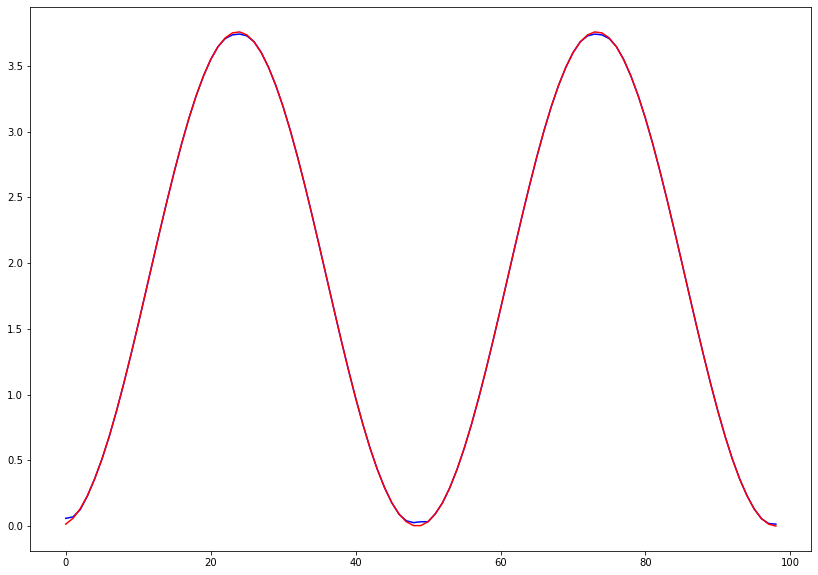

In [38]:
ax, figure = plt.subplots(figsize=(14,10))
plt.plot(df_ms['O'].values, 'b')
plt.plot(a, 'r')
#plt.plot(c, 'g')

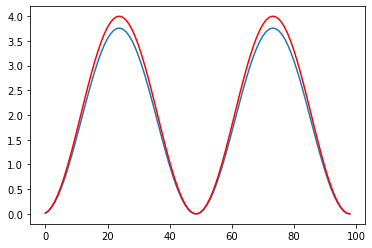

In [44]:
plt.plot(c)
plt.plot(df_ml_2[['Y_LL']].values - df_mr_2[['Y_LL']].values, 'r')

In [31]:
model_data = (2*np.cos(np.linspace(-np.pi, 3*np.pi, 100))+2)

print(model_data.max(), model_data.min(), model_data.max() - model_data.min())

3.9989930847663704 0.0 3.9989930847663704


### Checking the area

In [53]:
# defnining the left and right areas, total mouth area and diff in areas 
df_ml_2['Area_L']= area_of_triangle(df_ml_2[['X_UL', 'Y_UL', 'Z_UL']].values, 
                                      df_ml_2[['X_LL', 'Y_LL', 'Z_LL']].values, 
                                     df_ml_2[['X_LLeft', 'Y_LLeft', 'Z_LLeft']].values)
df_mr_2['Area_L'] = area_of_triangle(df_mr_2[['X_UL', 'Y_UL', 'Z_UL']].values, 
                                      df_mr_2[['X_LL', 'Y_LL', 'Z_LL']].values, 
                                     df_mr_2[['X_LLeft', 'Y_LLeft', 'Z_LLeft']].values)

df_ml_2['Area_R']= area_of_triangle(df_ml_2[['X_UL', 'Y_UL', 'Z_UL']].values, 
                                      df_ml_2[['X_LL', 'Y_LL', 'Z_LL']].values, 
                                     df_ml_2[['X_LR', 'Y_LR', 'Z_LR']].values)
df_mr_2['Area_R'] = area_of_triangle(df_mr_2[['X_UL', 'Y_UL', 'Z_UL']].values, 
                                      df_mr_2[['X_LL', 'Y_LL', 'Z_LL']].values, 
                                     df_mr_2[['X_LR', 'Y_LR', 'Z_LR']].values)



(99, 3)
(99, 3)
(99, 3)
(99, 3)
(99, 3)
(99, 3)
(99, 3)
(99, 3)
(99, 3)
(99, 3)
(99, 3)
(99, 3)


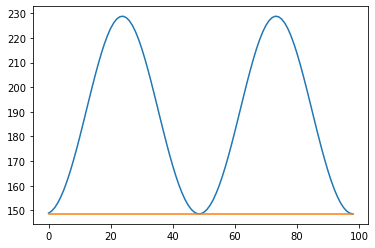

In [49]:
plt.plot(df_ml_2[['Area_L']].values)
plt.plot(df_mr_2[['Area_L']].values)

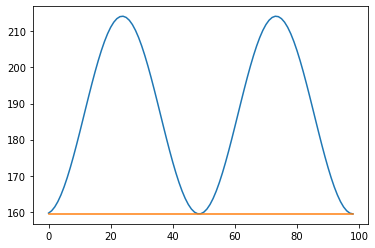

In [54]:
plt.plot(df_ml_2[['Area_R']].values)
plt.plot(df_mr_2[['Area_R']].values)

In [109]:
area_L_valid =  df_ml_2[['Area_L']].values - df_mr_2[['Area_L']].values
area_R_valid =  df_ml_2[['Area_R']].values - df_mr_2[['Area_R']].values
normal_right = df_ml_2[['Area_R']].values- df_mr_2[['Area_R']].values
normal_left = df_ml_2[['Area_L']].values - df_mr_2[['Area_L']].values
area_range = abs(normal_right - normal_left) 
area_total = normal_right + normal_left

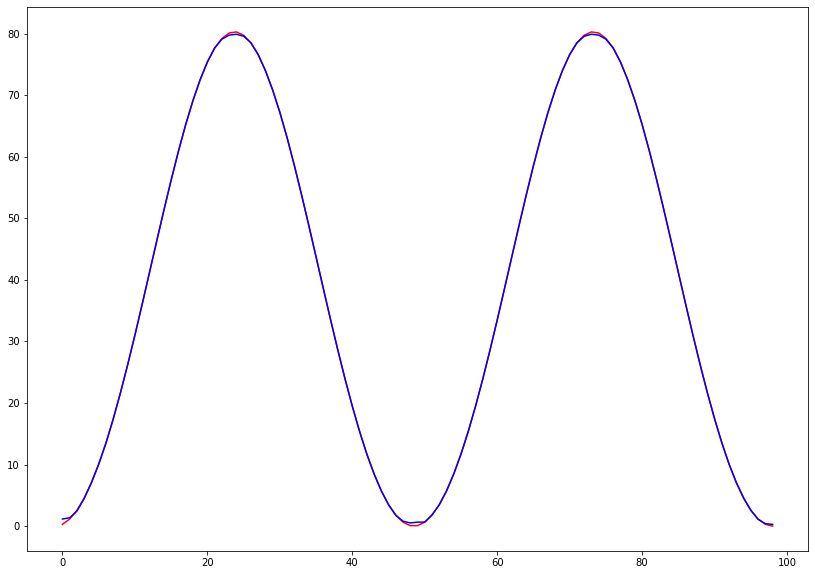

In [110]:
# validating the left area 
ax, figure = plt.subplots(figsize=(14,10))
plt.plot(area_L_valid, 'r' )
plt.plot(df_ms['lA_MOUTH'].values, 'b')

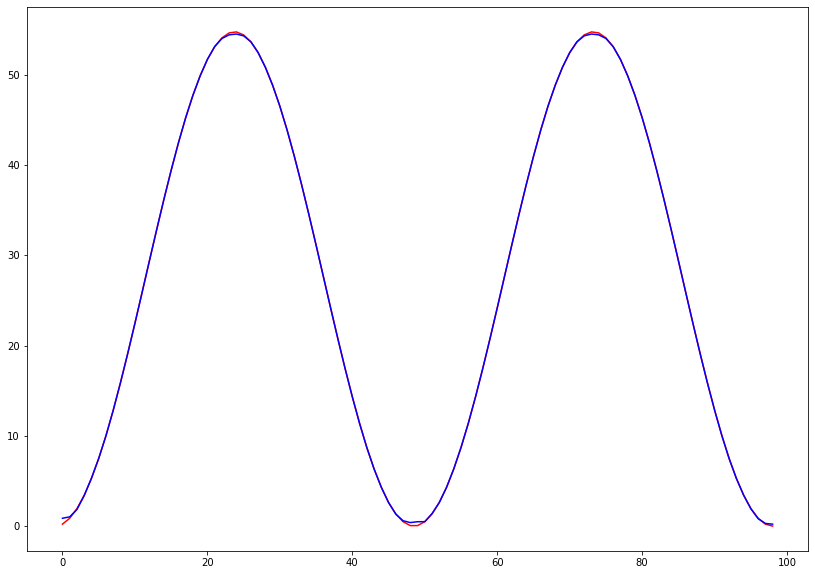

In [111]:
# validating the right area 
ax, figure = plt.subplots(figsize=(14,10))
plt.plot(area_R_valid, 'r' )
plt.plot(df_ms['rA_MOUTH'].values, 'b')

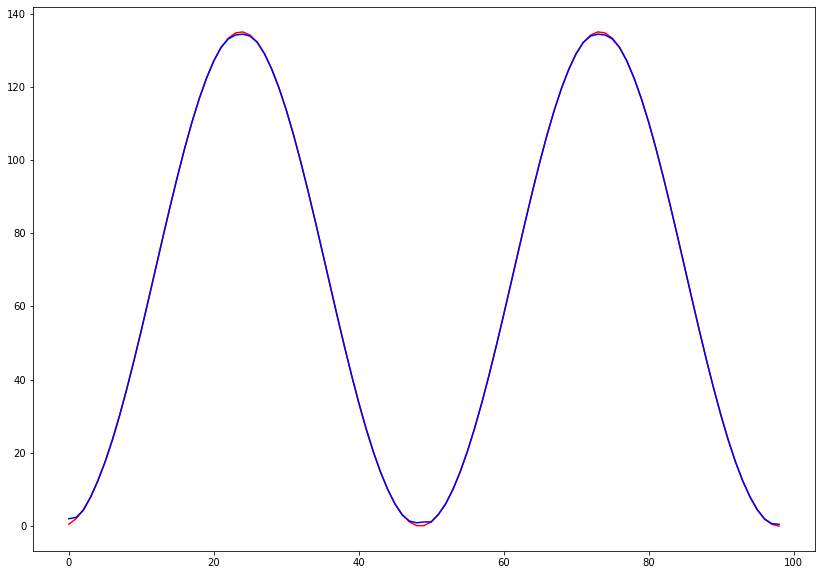

In [112]:
# validating the total area 
ax, figure = plt.subplots(figsize=(14,10))
plt.plot(area_total, 'r' )
plt.plot(df_ms['A_MOUTH'].values, 'b')

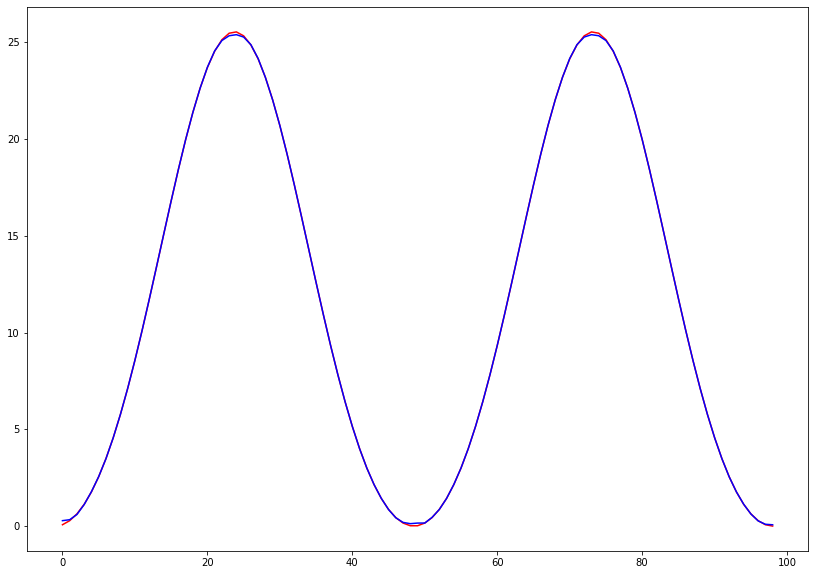

In [113]:
# validating the difference between the right and left area 
ax, figure = plt.subplots(figsize=(14,10))
plt.plot(area_range, 'r' )
plt.plot(df_ms['A_Mouth_diff'].values, 'b')

### Creating Animation and plots

### Making the scatter plot of landmark points

In [68]:
df_l_x_col = []
df_l_y_col = []

for col in df_ml.columns:
    
    if "landmark_" in col and "." not in col:
        df_l_x_col.append(col)
    elif "landmark_" in col and ".1" in col:
        df_l_y_col.append(col)
    
    
df_l_x = df_ml[df_l_x_col]
df_l_y = df_ml[df_l_y_col]
print(df_l_x.shape)
print(df_l_y.shape)


(100, 68)
(100, 68)


MovieWriter PillowWriter unavailable; using Pillow instead.


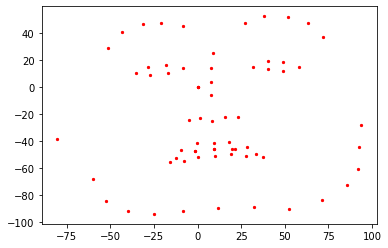

In [80]:



fig = plt.figure()
camera = Camera(fig)
for i in range(100):
    plt.scatter(df_l_x.values[i, :], -df_l_y.values[i,:], s=5, c = 'r')
    camera.snap()
animation = camera.animate()
animation.save('toy_data.gif', writer='PillowWriter', fps=2)

Text(0, 0.5, 'Range of Motion (cm)')

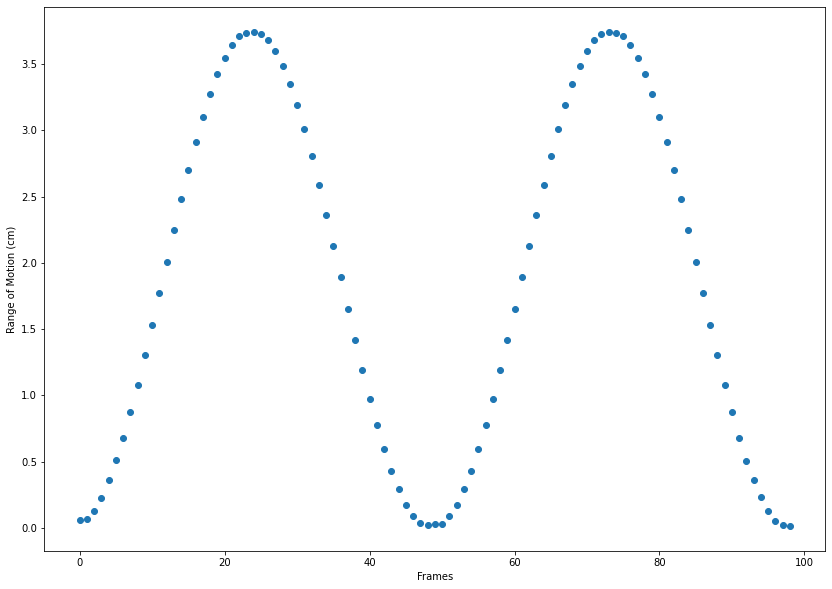

In [32]:
ax, figure = plt.subplots(figsize=(14,10))
plt.plot(df_ms['O'],'o')
plt.xlabel('Frames')
plt.ylabel('Range of Motion (cm)')

3.7281326768010814


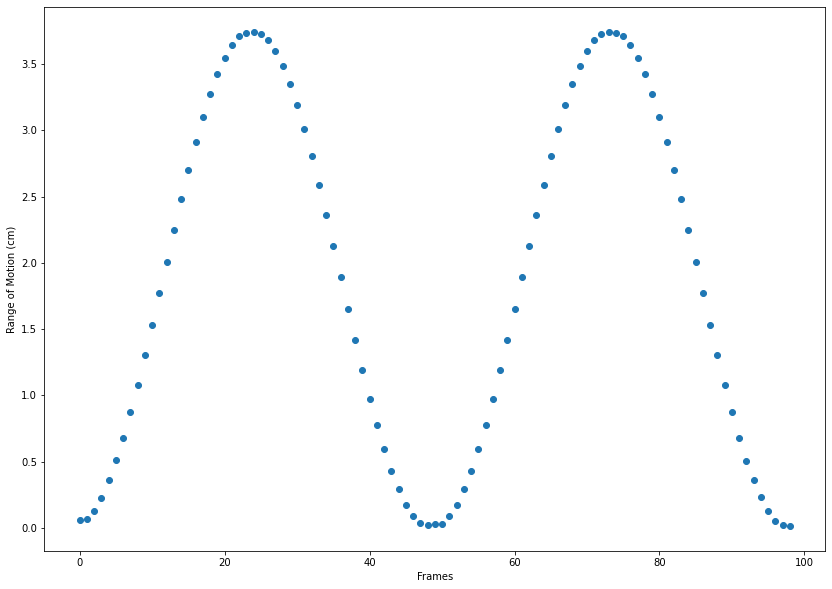

In [33]:
ax, figure = plt.subplots(figsize=(14,10))
plt.plot(df_ms['O'],'o')
plt.xlabel('Frames')
plt.ylabel('Range of Motion (cm)')


print(df_ms['O'].values.max() - df_ms['O'].values.min())

Text(0, 0.5, 'Range of Motion (cm)')

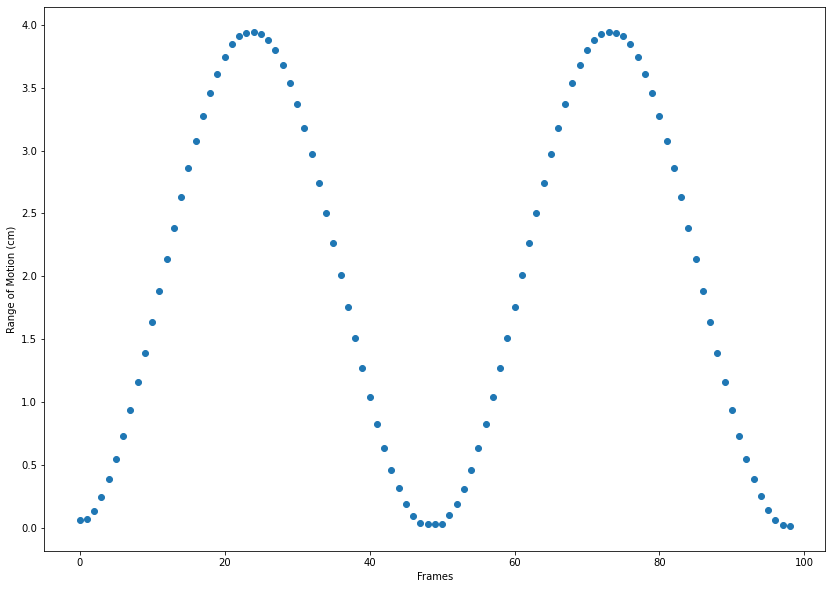

In [34]:
ax, figure = plt.subplots(figsize=(14,10))
plt.plot(df_ms['W'],'o')
plt.xlabel('Frames')
plt.ylabel('Range of Motion (cm)')

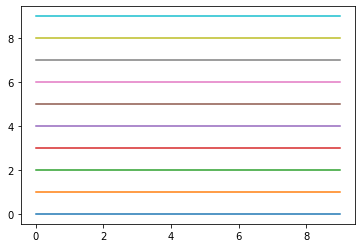

In [35]:
fig = plt.figure()
camera = Camera(fig)
for i in range(10):
    plt.plot([i] * 10)
    camera.snap()
animation = camera.animate()
animation.save('animation.gif', writer='PillowWriter', fps=2)

In [ ]:
.scatter(x[:, 0], y[:,0], s=5, c = 'r')

In [36]:
animation.save('animation.gif', writer='PillowWriter', fps=2)

MovieWriter PillowWriter unavailable; using Pillow instead.


In [37]:
animation.save('123resultsmovie.mp4')

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

In [ ]:
 Clinical